### Emittance evolution over many runs of the same study

- Plot the emittance evolution in x and y after sixtracklib tracking along with the theoretical expexted rate.
- The theoretical expected rate is computed from the functions in '../utils/my_functions.py' after defining the machine and the beam parameters in the present script.
- The simulation for each set of parameters is repeated multiple times. The mean and the standard deviation of the emittance values are computed over all runs (part 3) for each turn.
- The script can be used for amplitude noise AN and/or phase noise PN.
- The normalised emittance is used here.

**Important:** More than one levels of noise were applied at different time spans of the simulation time. The growth rate is estimated seperately for each one of the different time spans.

In [1]:
import sys
sys.path.append('../utils/')
from my_functions import *
import pickle
import numpy as np
import matplotlib.pyplot as plt

#### Plotting paramerters

In [2]:
params = {'legend.fontsize': 20,
          'figure.figsize': (9.5, 8.5),
          'axes.labelsize': 27,
          'axes.titlesize': 23,
          'xtick.labelsize': 27,
          'ytick.labelsize': 27,
          'image.cmap': 'jet',
          'lines.linewidth': 1,
          'lines.markersize': 5,
          'font.family': 'sans-serif'}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

#### 1) Load the data
a) Give the paths to the data in /afs/.

b) Load the values of the transverse emittance in a dictionary.

In [5]:
n_runs = 3 # number of runs that the simulation was repeated
total_turns = 1e5
f_rev = 43375.86 # [Hz] The revolution frequency of the machine 

In [6]:
path_to_data = '/afs/cern.ch/work/n/natriant/private/sixtracklib_example_crabcavity/tbt_from_GPUs/PNmytest_Achange_ayy1e5/'
name_template = 'tbt_'
noise_type = 'PN' # 'PN', 'AN', 'BOTH'

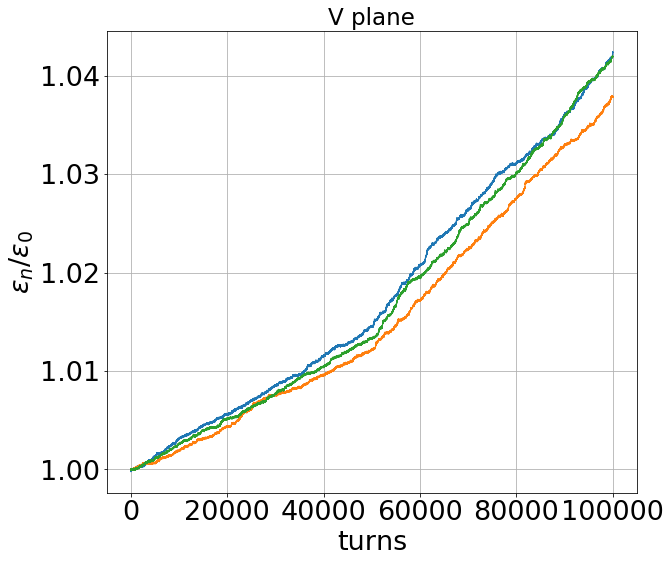

In [29]:
# phase noise
ex_dict = {} # type: dictionary
ey_dict = {}

for run in range(n_runs):
    temp_name = '{}'.format(run) # the suffix of the name of the current study
    # A. load the turn by turn data in a dictionary
    temp_dict = pickle.load( open(path_to_data+name_template+temp_name+'.pkl', "rb" ) )
    # B. Create a different list for each run and save the emittance values
    ex_dict[temp_name] = temp_dict['neps_x'] # ΑΝ
    ey_dict[temp_name] = temp_dict['neps_y']
    #print(len(ex_dict[temp_name]))
    plt.plot(ey_dict[temp_name]/ey_dict[temp_name][0])
plt.title('V plane')
plt.xlabel('turns')
plt.ylabel(r'$\epsilon_n / \epsilon_0$')
plt.grid()

#### 2) Here the mean and the standard deviation of the emittance values are computed over all runs. 

In [8]:
ex_mean = []
ey_mean = []

ex_std = []
ey_std = []


for turn in range(int(turns)):
    ex_temp = []
    ey_temp = []

    # keep all the emittance values for all the runs
    for run in range(n_runs):
        temp_name = '{}'.format(run)
        ex_temp.append(ex_dict[temp_name][turn])
        ey_temp.append(ey_dict[temp_name][turn])
    # calculate and append the mean of the emittance value for every turn
    ex_mean.append(np.mean(ex_temp))
    ey_mean.append(np.mean(ey_temp))
    # calculate and append the standard deviation of the emittance value for every turn
    ex_std.append(np.std(ex_temp))
    ey_std.append(np.std(ey_temp))    

#### 3) Convert turns to time [s], split to different time spans where the different level of noise was applied

In [58]:
# indices
noise_levels = 2 # number of noise levels
t1_init = 0
t1_end = int(total_turns/2)
t2_init = int(total_turns/2)
t2_end = int(total_turns)
# time spans in seconds
t1 = np.arange(t1_init, t1_end)/f_rev 
t2 = np.arange(t2_init, t2_end)/f_rev

#### 4) Plot evolution of the H and V (vertical emittance) emittance

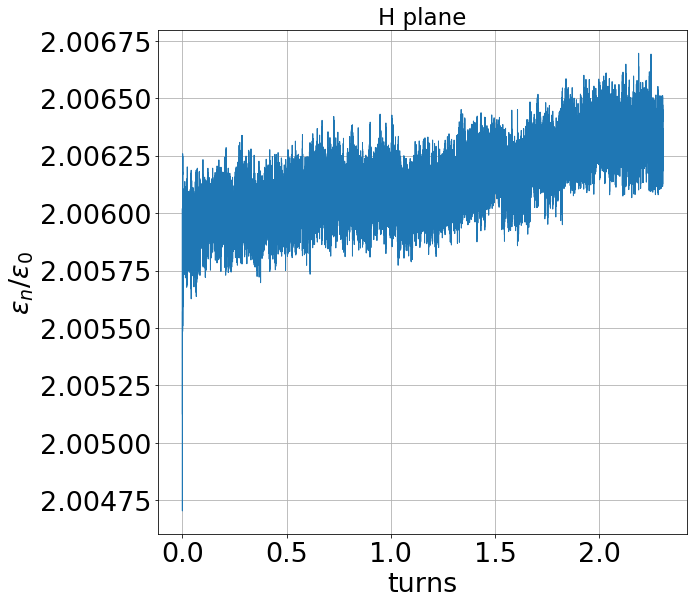

In [52]:
plt.plot(list(t1)+list(t2), np.array(ex_mean)*1e6, c='C0')
plt.xlabel('turns')
plt.ylabel(r'$\epsilon_n / \epsilon_0$')
plt.title('H plane')
plt.grid()
plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('H_270GeV_SPS_{}_1e5Nb_{}turns_mean{}runs.png'.format(noise_type, total_turns, n_runs))

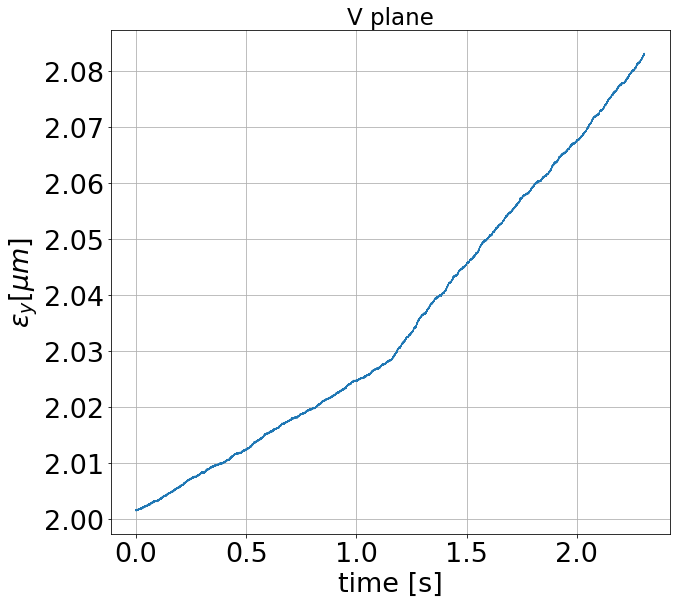

In [53]:
plt.plot(list(t1)+list(t2), np.array(ey_mean)*1e6, c='C0')    
plt.title('V plane')
plt.xlabel('time [s]')
plt.ylabel(r'$\epsilon_y [\mu m]$')
plt.grid()
plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('V_emittance_growth_270GeV_SPS_{}_V_1e5Nb_{}turns_mean{}runs.png'.format(noise_type, total_turns, n_runs))

#### 6) Plot evolution of the standard deviation $\sigma$ of the emittance values (in the vertical plane)

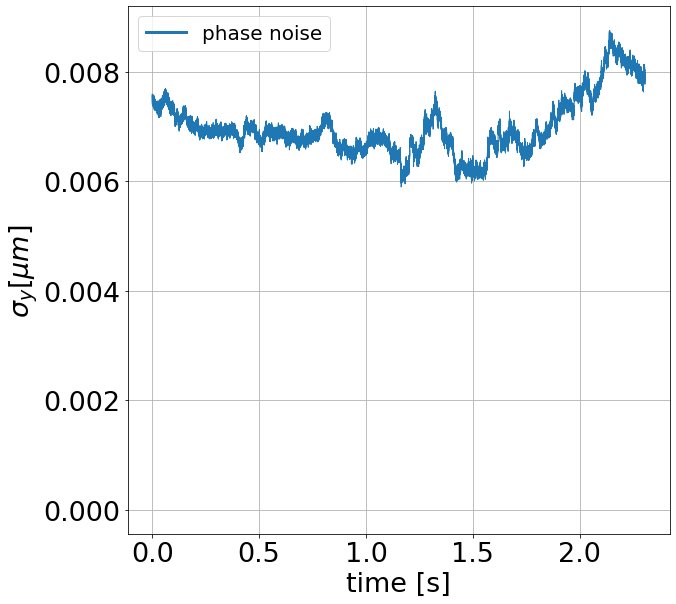

In [54]:
plt.plot(list(t1)+list(t2), np.array(ey_std)*1e6, c='C0')   
plt.plot(0,0,c='C0',  label = 'phase noise', linewidth = 3)   
plt.xlabel('time [s]')
plt.ylabel(r'$\sigma_y [\mu m]$')
plt.legend(loc=0)
plt.grid()
plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('V_std_270GeV_SPS_noCC_{}_VRF_1e5Nb_{}turns_mean{}runs.png'.format(noise_type, total_turns, n_runs))

#### 7) Compute the emittance growth rate via a linear fit
- Polynomial fit. The degree of the fitting polynomial is 1. 
- V plane only

In [59]:
# linear fit
[m1, b1], cov1 = np.polyfit(t1, ey_mean[t1_init:t1_end], 1, cov=True)
err1 = np.sqrt(np.diag(cov1))

[m2, b2], cov2 = np.polyfit(t2, ey_mean[t2_init:t2_end], 1, cov=True)
err2= np.sqrt(np.diag(cov2))

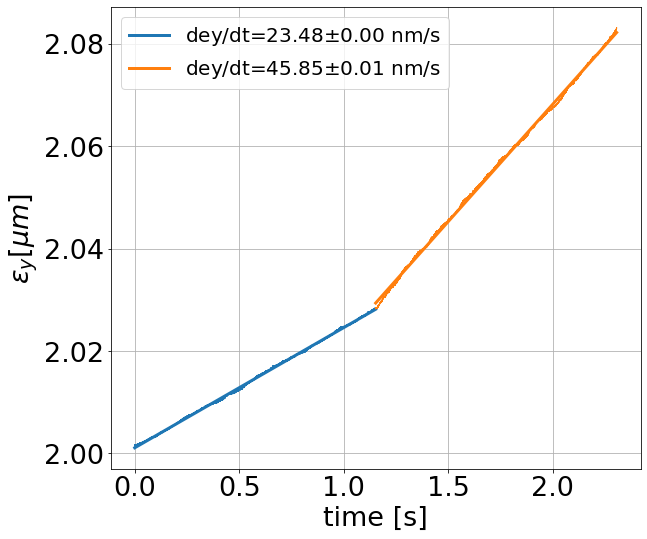

In [68]:
plt.plot(t1, np.array(ey_mean[t1_init:t1_end])*1e6, c='C0')
plt.plot(t1, (m1*t1+b1)*1e6, c = 'C0', label='dey/dt={0:.2f}'.format(m1*1e9)+'$\pm$'+'{0:.2f} nm/s'.format(err1[0]*1e9), linewidth = 3)
plt.plot(t2, np.array(ey_mean[t2_init:t2_end])*1e6, c='C1')
plt.plot(t2, (m2*t2+b2)*1e6, c = 'C1', label='dey/dt={0:.2f}'.format(m2*1e9)+'$\pm$'+'{0:.2f} nm/s'.format(err2[0]*1e9), linewidth = 3)
plt.xlabel('time [s]')
plt.ylabel(r'$\epsilon_y [\mu m]$')
plt.grid()
plt.legend()

### 9) Compute the theoretically expected rate
- Define the machine and beam parameters
- Define the levels of noise for A, the indices 1,2 correspond to the different time spans
- Compute the expected rate from the functions in '../utils/my_functions.py'
- Define the colors according to the type of the study

In [73]:
# Machine parameters
betay = 73 # 73 m at CC2, 76 m at CC1
Vcc = 1e6# V
frev = 43.45e3 # Hz
Eb = 270e9 # eV
beta_0 = 0.999999
gamma_0 = 287.7
sigma_z = 0.155 # m
f_CC = 400.789e6 # CC frequency in Hz
clight = 299792458 # m/s
A_phase_1 = 1e-8 # rms kick in the simulation of the phase noise
A_phase_2 = np.sqrt(2)*1e-8
A_amplitude_1 = 0 # rms kick in the simulation of the amplitude noise
A_amplitude_2 = 0
scale_factor = Eb/Vcc # scaling factor to rms noise, σ
# Compute the PSD in rad^2/Hz and V^2/Hz
PSD_phi_1 = (A_phase_1 * scale_factor)**2/frev # rad^2/Hz
PSD_phi_2 = (A_phase_2 * scale_factor)**2/frev # rad^2/Hz
#PSD_phi = 1.4e-10
PSD_A_1 = (A_amplitude_1 * scale_factor)**2/frev # V^2/Hz
PSD_A_2 = (A_amplitude_2 * scale_factor)**2/frev
print(PSD_phi_1, PSD_phi_2)

1.6777905638665135e-10 3.355581127733027e-10


In [75]:
# Compute the correction factor due to the bunch length
sigma_phi = bunch_length_m_to_rad(sigma_z, clight, f_CC)
CDeltaphi = cmpt_bunch_length_correction_factor(sigma_phi, 'PN')
CDeltaA = cmpt_bunch_length_correction_factor(sigma_phi, 'AN')
print('CDeltaPhi = {}, CDeltaA = {}'.format(CDeltaphi, CDeltaA))

if noise_type == 'PN':
    expected_growth_1 = emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaphi, PSD_phi_1)*beta_0*gamma_0 # m/s
    expected_growth_2 = emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaphi, PSD_phi_2)*beta_0*gamma_0 # m/s
    my_color = 'C0'
    fill_bewtween_color = 'lightblue'
elif noise_type == 'AN':
    expected_growth_1 = emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaA, PSD_A_1)*beta_0*gamma_0 # m/s
    expected_growth_2 = emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaA, PSD_A_2)*beta_0*gamma_0 # m/s
    my_color = 'C1'
    fill_bewtween_color = 'moccasin'
else:
    my_color = 'C2'
    expected_growth_phi_1 = emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaphi, PSD_phi_1)*beta_0*gamma_0 # m/s 
    expected_growth_phi_2 = emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaphi, PSD_phi_2)*beta_0*gamma_0 # m/s 
    expected_growth_A_1 = emit_growth_amplitude_noise(betay, Vcc, frev, Eb, CDeltaA, PSD_A_1)*beta_0*gamma_0 # m/s
    expected_growth_A_2 = emit_growth_amplitude_noise(betay, Vcc, frev, Eb, CDeltaA, PSD_A_2)*beta_0*gamma_0 # m/s
    expected_growth_1 = expected_growth_phi_1 + expected_growth_A_1
    expected_growth_2 = expected_growth_phi_2 + expected_growth_A_2

print('expected growth 1 = {} nm/s'.format(expected_growth_1*1e9))
print('expected growth 2 = {} nm/s'.format(expected_growth_2*1e9))

CDeltaPhi = 0.5168486015622045, CDeltaA = 0.24157569921889774
expected growth 1 = 23.582259735020834 nm/s
expected growth 2 = 47.16451947004167 nm/s


#### 8) Plot fill between

#### A) y axis: emittance values

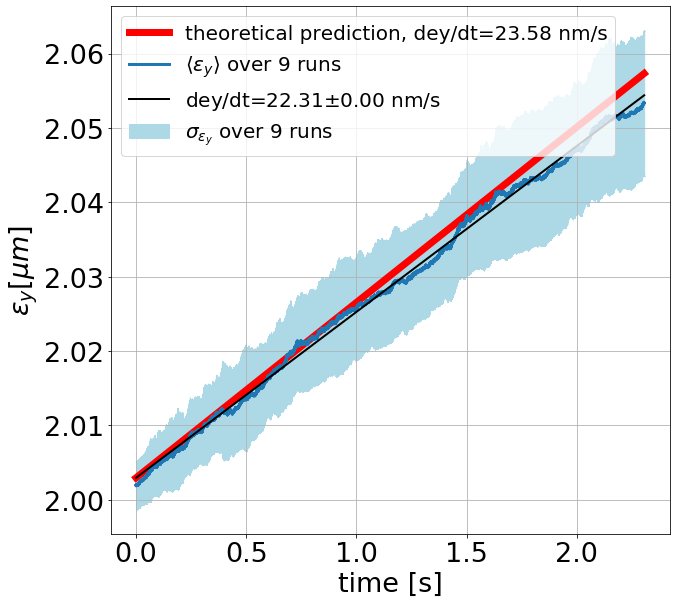

In [15]:
# std over all runs
if noise_type == 'BOTH': # just for customizing purposes
    plt.fill_between(time, np.array(ey_mean)*1e6 - np.array(ey_std)*1e6, np.array(ey_mean)*1e6 + np.array(ey_std)*1e6, facecolor=my_color, alpha=0.2,  label=r'$\sigma_{\epsilon_y}$'+ ' over {} runs'.format(n_runs))
else:
    plt.fill_between(time, np.array(ey_mean )*1e6 - np.array(ey_std)*1e6, np.array(ey_mean)*1e6 + np.array(ey_std)*1e6, color=fill_bewtween_color, label=r'$\sigma_{\epsilon_y}$'+ ' over {} runs'.format(n_runs))
# expected slope from analytical calculations
plt.plot(time, (expected_growth*time+b)*1e6, c='r', linewidth=7, label='theoretical prediction, dey/dt={:.2f} nm/s'.format(expected_growth*1e9))

# emittance values obtained from the simulation averaged over turns
plt.plot(time, np.array(ey_mean)*1e6, c=my_color, linewidth=3, label=r'$\langle \epsilon_y \rangle $'+' over {} runs'.format(n_runs))

# linear fit on the emittance values obtained from the simulation averaged over turns
plt.plot(time, (m*time+b)*1e6, c = 'k', label='dey/dt={0:.2f}'.format(m*1e9)+'$\pm$'+'{0:.2f} nm/s'.format(err[0]*1e9), linewidth = 2)



plt.xlabel('time [s]')
plt.ylabel(r'$\epsilon_y [\mu m]$')
plt.legend(loc=0)
plt.grid()
#plt.ylim(1.98, 2.10)
#plt.ylim(1.98, 2.6)

plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('V_emittance_growth_rate_270GeV_SPS_{}Apn3e-8_Aan5e-9_VRF2_37MV_1e5Nb_1e5turns_mean{}run_fill_between.png'.format(noise_type, n_runs))

#### B) y axis: emittance values after substracting the initial emittance

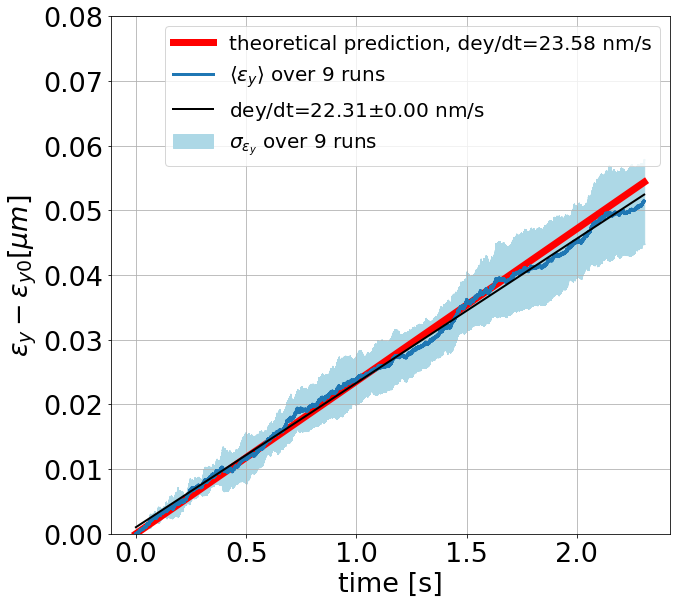

In [19]:
initial_std = ey_std[0]
initial_mean_emittance = ey_mean[0]
# std over all runs
if noise_type == 'BOTH': # just for customizing purposes
    plt.fill_between(time, np.array(ey_mean-initial_mean_emittance )*1e6 - np.array(ey_std-initial_std)*1e6, np.array(ey_mean-initial_mean_emittance)*1e6 + np.array(ey_std-initial_std)*1e6, facecolor=my_color, alpha=0.2, label=r'$\sigma_{\epsilon_y}$'+ ' over {} runs'.format(n_runs))
else:
    plt.fill_between(time, np.array(ey_mean-initial_mean_emittance )*1e6 - np.array(ey_std-initial_std)*1e6, np.array(ey_mean-initial_mean_emittance)*1e6 + np.array(ey_std-initial_std)*1e6, color=fill_bewtween_color, label=r'$\sigma_{\epsilon_y}$'+ ' over {} runs'.format(n_runs))

# expected slope from analytical calculations
plt.plot(time, (expected_growth*time)*1e6, c='r', linewidth=7, label='theoretical prediction, dey/dt={:.2f} nm/s'.format(expected_growth*1e9))

# emittance values obtained from the simulation averaged over turns
plt.plot(time, np.array(ey_mean-initial_mean_emittance)*1e6, c=my_color, linewidth=3, label=r'$\langle \epsilon_y \rangle $'+' over {} runs'.format(n_runs))

# linear fit on the emittance values obtained from the simulation averaged over turns
#plt.plot(time, (m_pn*time)*1e6, c = 'k', label='dey/dt={0:.2f}'.format(m_pn*1e9)+'$\pm$'+'{0:.2f} nm/s'.format(err_pn[0]*1e9), linewidth = 2)
plt.plot(time, (m*time+b-initial_mean_emittance)*1e6, c = 'k', label='dey/dt={0:.2f}'.format(m*1e9)+'$\pm$'+'{0:.2f} nm/s'.format(err[0]*1e9), linewidth = 2)

plt.xlabel('time [s]')
plt.ylabel(r'$\epsilon_y - \epsilon_{y0} [\mu m]$')
plt.legend(loc=0)
plt.grid()
plt.ylim(0, 0.08)
#plt.ylim(0, 0.6)

plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('V_emit_growth_rate_substract_initial_emittance_270GeV_SPS_{}_PN1e-8_VRF2_37MV_1e5Nb_1e5turns_mean{}run_fill_between.png'.format(noise_type, n_runs))